In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# test data
xi = np.array([0.0, 0.9, 2.1, 3.0, 4.5, 5.5, 10.])
zi = np.array([0.0, 1.0, 1.5, 2.7, 5.0, 6.0, 7.0])
tens = 1.0

In [3]:
class TensionSpline(object):
    def __init__(self, ti, yi, tension):
        self.ti = ti
        self.yi = yi
        ni = len(yi)
        self.dt = np.diff(ti)
        assert(np.min(self.dt) > 0)
        self.sigma = tension / np.max(self.dt)
        dydt = np.diff(yi)/self.dt
        self.tau = self.sigma * self.dt
        s1 = 1.0 / (self.dt * self.sigma**2)
        s2 = -2*self.dt*np.exp(-self.tau)/(self.tau*np.expm1(-2*self.tau))

        n = ni - 2
        w = self.dt / (self.tau*np.tanh(self.tau)) - s1
        sdiag = s1[1:n] - s2[1:n]
        diag = w[:n] + w[1:] 
        b = np.diff(dydt)
        T = np.diag(sdiag,-1) + np.diag(sdiag,1) + np.diag(diag)
        self.ypps = np.zeros(ni)
        self.ypps[1:1+n] = np.linalg.solve(T,b)
        
    # interpolation function uses ti, yi, dt, tau, sigma, ypps    
    def __call__(self, t_):
        t = t_*np.ones(1) if np.isscalar(t_) else t_
        res = np.zeros(np.shape(t))
        res[np.where(t<=self.ti[0])] = self.yi[0]
        res[np.where(t>=self.ti[-1])] = self.yi[-1]
        gi = np.where( (self.ti[0] < t) & (t < self.ti[-1]) )
        tg = t[gi]
        ii = np.array([np.argmin(self.ti<tx) for _, tx in enumerate(tg)])
        u = (self.ti[ii] - tg) / self.dt[ii-1]
        v = 1-u
        den = -np.expm1(-2*self.tau[ii-1])
        eum = np.exp( (u-1)*self.tau[ii-1] )
        eup = np.exp(-(u+1)*self.tau[ii-1] )
        evm = np.exp( (v-1)*self.tau[ii-1] )
        evp = np.exp(-(v+1)*self.tau[ii-1] )
    
        sig2 = self.sigma**2
        p = ( ((eum - eup) / den) - u ) / sig2
        q = ( ((evm - evp) / den) - v ) / sig2
        g = self.ypps[ii-1]*p + self.ypps[ii]*q
        res[gi] = u*self.yi[ii-1] + v*self.yi[ii] + g
    
        return res[0] if np .isscalar(t_) else res

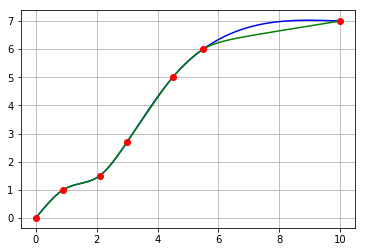

In [4]:
f = TensionSpline(xi, zi, tens)
g = TensionSpline(xi, zi, 10*tens)
x = np.linspace(0,10,200)
plt.plot(x, f(x),'b')
plt.plot(x, g(x),'g')
plt.plot(xi, zi, 'ro')
plt.grid(True)
plt.show()